# Goal

We've developed an ice-sheet model emulator for both the RCP8.5 scenario and the LIG scenario in **construct_rcp_emulator.ipynb** and **construct_lig_emulator.ipynb** respectively.

The purpose of sampling from the LIG emulator is to inform our sampling of the RCP8.5 emulator, and for that we need LIG observational constraints. In this code we develop posterior distributions of CREVLIQ and CLIFVMAX, illustrating how assumptions about the shape and magnitude of the LIG observational record influences those posteriors.

The specific LIG constraint distributions are drawn from the results of **sample_lig_emulator.ipynb**. We explore the following constraint distributions:

- Unconstrained: Distribution with uniform equal weights across all parameters
- D20-U: DeConto et al. (2020) Uniform distribution
- D20-N: DeConto et al. (2020) distribution Assumed Gaussian
- E19-U: Edwards et al. (2020) Uniform distribution based on DeConto and Pollard (2016)
- K09-125ka: Kopp et al. (2009) GP Distribution Time Slice at 125ka
- K09-Max-3kyrSmooth: Kopp et al. (2009) GP Distribution Maximums of Samples (smoothed over 3kyr)

We also explore the effects of two sets of hypothetical LIG constraints:

- High and low distributions: Assuming LIG AIS>6 m and LIG AIS<3.5 m, respectively
- Narrower D20-U: Sensitivity to reduced uncertainties in LIG estimates

Additionally, we compute RCP8.5 distributions as a function of (conditional on) LIG sea level contributions.

# Setup

In [1]:
# import the relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy

In [2]:
# define the colormap
plt.set_cmap('viridis')
# define the save path for our plots
save_path='./figures/'
# import a series of colors for the prior vs. constraints plot
from lig_utilities import call_scm_cmap, uniform_cmap_slices
cmap=call_scm_cmap('roma')
cols=uniform_cmap_slices(cmap,5,col_range=[0,1.0])[::-1]
# import the rectangle feature
import matplotlib.patches as patches
# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

<Figure size 432x288 with 0 Axes>

In [3]:
# import the GPflow package to load the GP model and sample
import gpflow
from lig_utilities import normalize, denormalize
# load the modules to compute the statistics
from lig_utilities import posterior_densities_rcp85, find_quantile_i, find_quantile_ts
# import tensorflow so we can restore the trained model
import tensorflow as tf

# Data and Model

Restore the trained GPflow model for RCP8.5 from which to sample.

### Load the Training Data (to reconstruct the GP model)

In [4]:
# load the training data from the pickle and print its keys
train_dat=pickle.load(open( "./models/rcp_model_traindata.pk1", "rb" ) )
train_dat.keys()

dict_keys(['clifvmax', 'Y_train', 'model_name', 'kernel_code', 'crevliq', 'time', 'X_train'])

### Restore the Trained GP model

In [5]:
# reconstruct the GP model
with gpflow.defer_build():
    
    # define the kernel
    k = eval(train_dat['kernel_code'])

    # create the model
    m = gpflow.models.GPR(train_dat['X_train'], \
        train_dat['Y_train'].reshape(np.size(train_dat['Y_train']),1), kern=k, name=train_dat['model_name'])
    
    # Fix the nugget term
    m.likelihood.variance = 1e-06
    m.likelihood.trainable=False
  
# construct and compile the tensorflow session
tf.global_variables_initializer()
tf_graph = m.enquire_graph()
tf_session = m.enquire_session()
m.compile( tf_session )

# create the saver object and load the archived model object
saver = tf.train.Saver()
save_path = saver.restore(tf_session, "./models/rcp_model.ckpt")
print("Model loaded from path: %s" % save_path)

# anchor the model to restore optimized hyperparameters
m.anchor(tf_session)

INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


INFO:tensorflow:Restoring parameters from ./models/rcp_model.ckpt


Model loaded from path: None


In [6]:
# uncomment to verify the hyperparameters are correctly restored
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
rcp_model/kern/kernels/0/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,0.5012107704313864
rcp_model/kern/kernels/0/kernels/0/variance,Parameter,None,+ve,True,(),True,1.830591620175421
rcp_model/kern/kernels/0/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,0.4548666355127329
rcp_model/kern/kernels/0/kernels/1/variance,Parameter,None,+ve,True,(),True,1.8310064734237486
rcp_model/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,2.7567453807220614
rcp_model/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,2731.897366783309
rcp_model/likelihood/variance,Parameter,None,+ve,False,(),True,1e-06


### Load CLIFVMAX/CREVLIQ likelihoods

Load the CREVLIQ/CLIFVMAX probabilities given the LIG constraint scenarios defined in **sample_lig_emulator.ipynb**. These are now the likelihood probabilities with which we weight the sampled RCP8.5 timeseries.

In [7]:
cc_likelihoods=pickle.load( open( "./models/cc_likelihoods.pk1", "rb" ) )

### Load the LHC Design

In [8]:
# load the design from pickle
lhd=pickle.load(open( "./models/lig_lhc_design_10000.pk1", "rb" ) )
n_samples=len(lhd)

### Define Normalized Time grid for Sampling

In [9]:
# define the normalized time grid, every ten years from 1995 to 2200
sample_time=np.linspace(0,1.0,22)
#denorm_time=denormalize(sample_time,np.max(train_dat['time']),np.min(train_dat['time']))
denorm_time=denormalize(sample_time,2200,1990)
print(denorm_time)

[ 1990.  2000.  2010.  2020.  2030.  2040.  2050.  2060.  2070.  2080.
  2090.  2100.  2110.  2120.  2130.  2140.  2150.  2160.  2170.  2180.
  2190.  2200.]


Note that the emulator will be truncated at 2150 in our analyses to reduce edge effects in the GP model emulator.

# Sampling and Results

With the data loaded in, and the GP model restored, we now sample from the model, weighting the samples according to the CREVLIQ/CLIFVMAX set likelihoods associated with each set of different LIG constraints (developed and saved out in **sample_lig_emulator.ipynb**). 

We find posterior distributions of the sea level samples and plot their timeseries.

## Prior RCP8.5 Distribution

The "prior" is given by assuming that all CREVLIQ/CLIFVMAX contributions are equally likely, i.e. the emulator is unconstrained over the parameter range of the training ensemble.

In the process of finding the prior below, we use the modules needed to condition our posteriors and plot the PDFs of sea level contributions from AIS through time.

In [10]:
# create the sample grid with the LHC design (at each time point)
X_sample=np.empty((len(lhd)*len(sample_time),3),dtype='float')
for t in range(len(sample_time)):
    
    # index in array creation
    t_first=t*len(lhd)
    t_last=t_first+len(lhd)
    
    # fill an array with out time period
    t_fill=np.empty(len(lhd))
    t_fill.fill(sample_time[t])
    
    # fill the sample grid array
    X_sample[t_first:t_last,:]=np.vstack((np.vstack((t_fill[:],lhd[:,0])),lhd[:,1])).T

In [11]:
# sample from the model
sample_mean,sample_var=np.squeeze(m.predict_y(X_sample))

# reshape into the prior
prior_mean=sample_mean.reshape(len(sample_time),len(lhd))
prior_var=sample_var.reshape(len(sample_time),len(lhd))

### Visualize the Samples Mean

In [12]:
# denormalize the training grid
denorm_prior_x=denormalize(lhd[:,1],np.max(train_dat['clifvmax']),np.min(train_dat['clifvmax']))
denorm_prior_y=denormalize(lhd[:,0],np.max(train_dat['crevliq']),np.min(train_dat['crevliq']))
ns1,ns2 = len(lhd[:,1]),len(lhd[:,0])
denormed_lhd=np.asarray([denorm_prior_y,denorm_prior_x]).T

In [13]:
# get the time location for thge plot
ind2100=np.where(denorm_time==2100)
ind2150=np.where(denorm_time==2150)

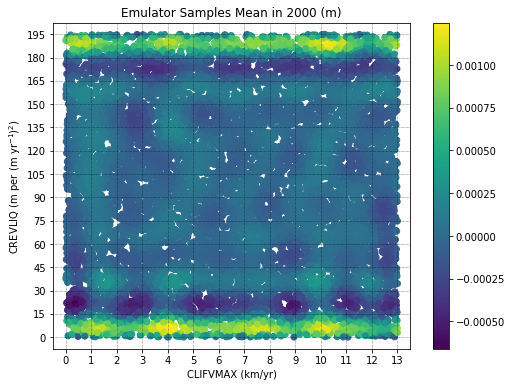

In [14]:
# plot the means of the samples in 2000 across the parameter space
samples_mean_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=np.squeeze(prior_mean[1,:]),edgecolors='face')
cb=plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title('Emulator Samples Mean in 2000 (m)')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

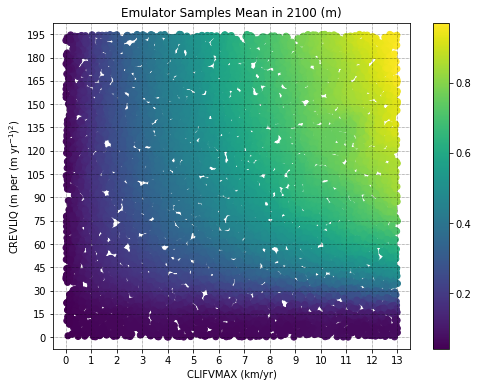

In [15]:
# plot the means of the samples in 2100 across the parameter space
samples_mean_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=np.squeeze(prior_mean[ind2100,:]),edgecolors='face')
cb=plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title('Emulator Samples Mean in 2100 (m)')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

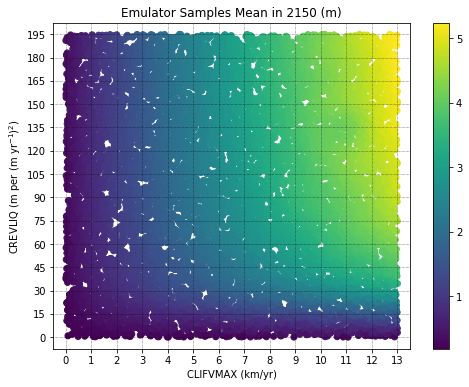

In [16]:
# plot the means of the samples in 2150 across the parameter space
samples_mean_fig=plt.figure(figsize=(8,6))
plt.scatter(denormed_lhd[:,1],denormed_lhd[:,0],c=np.squeeze(prior_mean[ind2150,:]),edgecolors='face')
cb=plt.colorbar()
plt.xticks(train_dat['clifvmax'])
plt.yticks(train_dat['crevliq'])
plt.xlim([-0.5,13.5])
plt.ylim([-7.5,202.5])
plt.title('Emulator Samples Mean in 2150 (m)')
plt.xlabel('CLIFVMAX (km/yr)')
plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
plt.grid()
plt.show()

### Calculate and Visualize the Prior

In [17]:
# import the scipy packages needed to define distrubutions
from scipy.stats import norm

# define the prior pdf from the GP emulator, note that its properties/methods (e.g. "pdf")
# will have shape (ntime,nsamples) (i.e. or the same as "prior_mean"/"prior_var")
prior_norm=norm(loc=prior_mean,scale=np.sqrt(prior_var))

# create the bins to perform our density estimation
sl_step=1e-03
min_val,max_val=-0.5,9.5
step_locs=np.arange(min_val,max_val+sl_step,step=sl_step)

In [18]:
# find the prior density through time (with "equal" likelihoods from the CC priors)
prior_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['equal'])

In [19]:
# define the quantiles we want
q=np.asarray([5,25,50,75,95],dtype='int')

# find the quantiles for each time
quants_prior=find_quantile_ts(prior_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


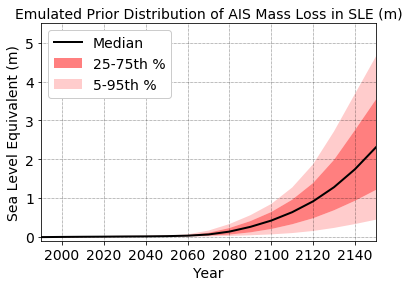

In [20]:
prior_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_prior[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_prior[0,:].T,
                    y2=quants_prior[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_prior[1,:].T,
                    y2=quants_prior[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_prior[3,:].T,
                    y2=quants_prior[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100
#rect=patches.Rectangle(xy=(1990,-0.2),width=110,height=1.3,linewidth=1.5, \
#                            linestyle='-',edgecolor='k',alpha=0.8,facecolor='none',zorder=50)
#ax.add_patch(rect)

plt.xlabel('Year',fontsize=14)
plt.ylabel('Sea Level Equivalent (m)',fontsize=14)
plt.title('Emulated Prior Distribution of AIS Mass Loss in SLE (m)',fontsize=14)
plt.legend(loc='upper left',fontsize=14,framealpha=1.0)
plt.axis('tight')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim([-0.1,5.5])
plt.xlim([1990, 2150])
plt.show()

In [21]:
# save the plot out
save_path='./figures/'
savename='Fig3.pdf'
prior_pdf_2150_ts.savefig(save_path+savename)

## D20-U: DeConto et al. (2020) Uniform distribution

We can begin to look at how the above PDF through time are affected by various LIG constraints (through the associated CREVLIQ/CLIFVMAX sampled parameter set likelihoods). We begin with the DeConto et al. (2020) uniform distribution:

In [22]:
cc_likelihoods.keys()

dict_keys(['range_10', 'e19_U', 'range_90', 'D20_U', 'k09_max_5kyr', 'range_50', 'k09_max_3kyr', 'low_U', 'D20_N', 'range_25', 'range_75', 'equal', 'k09_max_1kyr', 'k09_125', 'high_U'])

In [23]:
# find the posterior density through time
D20_U_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['D20_U'])

# find the quantiles for each time
quants_D20_U=find_quantile_ts(D20_U_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


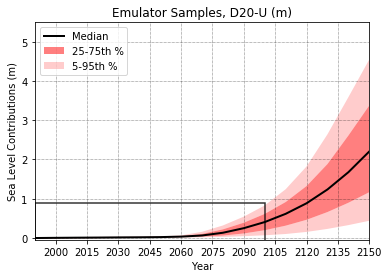

In [24]:
D20_U_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_D20_U[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_D20_U[0,:].T,
                    y2=quants_D20_U[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_D20_U[1,:].T,
                    y2=quants_D20_U[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_D20_U[3,:].T,
                    y2=quants_D20_U[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100
rect=patches.Rectangle(xy=(1990,-0.2),width=110,height=1.1,linewidth=1.5, \
                            linestyle='-',edgecolor='k',alpha=0.8,facecolor='none',zorder=50)
ax.add_patch(rect)

plt.xlabel('Year')
plt.ylabel('Sea Level Contributions (m)')
plt.title('Emulator Samples, D20-U (m)')
plt.legend(loc='upper left')
plt.axis('tight')
plt.xticks(np.linspace(2000,2150,11))
plt.yticks(np.linspace(0,10,11))
plt.ylim([-0.05,5.5])
plt.xlim([1990, 2150])
plt.show()

## D20-N: DeConto et al. (2019) Uniform distribution assuming Gaussian

In [25]:
# find the posterior density through time
D20_N_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['D20_N'])

# find the quantiles for each time
quants_D20_N=find_quantile_ts(D20_N_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


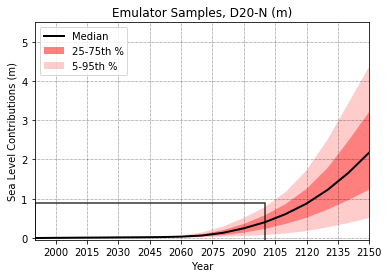

In [26]:
D20_N_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_D20_N[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_D20_N[0,:].T,
                    y2=quants_D20_N[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_D20_N[1,:].T,
                    y2=quants_D20_N[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_D20_N[3,:].T,
                    y2=quants_D20_N[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100
# rect=patches.Rectangle(xy=(1990,-0.2),width=110,height=1.1,linewidth=1.5, \
#                             linestyle='-',edgecolor='k',alpha=0.8,facecolor='none',zorder=50)
# ax.add_patch(rect)

plt.xlabel('Year')
plt.ylabel('Sea Level Contributions (m)')
plt.title('Emulator Samples, D20-N (m)')
plt.legend(loc='upper left')
plt.axis('tight')
plt.xticks(np.linspace(2000,2150,11))
plt.yticks(np.linspace(0,10,11))
plt.ylim([-0.05,5.5])
plt.xlim([1990, 2150])
plt.show()

## Narrower D20-U: Fixed Central Value, Varying Width

Calculate the posteriors showing the sensitivity of the future projections to a narrowing of the D20-U LIG constraint.

In [27]:
# find the posterior densities through time
range90_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['range_90'])
range75_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['range_75'])
range50_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['range_50'])
range25_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['range_25'])
range10_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['range_10'])

# find the quantiles for each time
quants_range90_U=find_quantile_ts(range90_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)
quants_range75_U=find_quantile_ts(range75_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)
quants_range50_U=find_quantile_ts(range50_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)
quants_range25_U=find_quantile_ts(range25_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)
quants_range10_U=find_quantile_ts(range10_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

## Explore LIG efficacy vs. prior over time

Here we plot one of the Narrower D20-U constraint distributions (50% narrower) over time vs. the prior to show how the constraint magnitude increases over time (associated with skew, see analyses below).

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


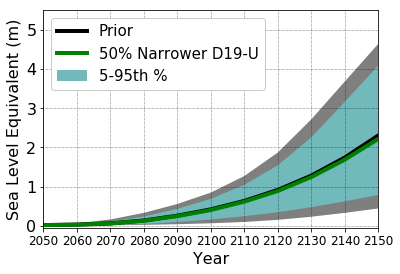

In [28]:
compare_red_prior_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_prior[2,:],c='k',label='Prior',lw=4)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_prior[0,:].T,
                    y2=quants_prior[4,:].T,
                    alpha=0.50, facecolor='k')
plt.plot(denorm_time,quants_range50_U[2,:],c='g',label='50% Narrower D19-U',lw=4)
ax.fill_between(denorm_time, 
                    y1=quants_range50_U[0,:].T,
                    y2=quants_range50_U[4,:].T,
                    alpha=1., facecolor=[113/256,186/256,188/256],label='5-95th %')

plt.xlabel('Year',fontsize=16)
plt.ylabel('Sea Level Equivalent (m)',fontsize=16)
plt.legend(loc='upper left',fontsize=15,framealpha=1.0)
plt.xticks(np.linspace(2040,2160,13),fontsize=12)
plt.yticks(np.linspace(0,10,11),fontsize=16)
plt.ylim([-0.05,5.5])
plt.xlim([2050, 2150])
plt.show()

In [29]:
# save the plot out
savename='Fig7a.pdf'
compare_red_prior_ts.savefig(save_path+savename)

## Explore LIG high vs. low

Here we find the posterior distributions associated with high (LIG AIS > 6m) and low (LIG AIS < 3.5m) LIG constraints.

In [30]:
# find the posterior densities through time
high_U_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['high_U'])
low_U_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['low_U'])

# find the quantiles for each time
quants_high_U=find_quantile_ts(high_U_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)
quants_low_U=find_quantile_ts(low_U_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


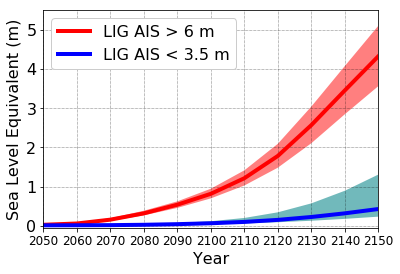

In [31]:
compare_high_low_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_high_U[2,:],c='r',label='LIG AIS > 6 m',lw=4)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_high_U[0,:].T,
                    y2=quants_high_U[4,:].T,
                    alpha=0.50, facecolor='r')
plt.plot(denorm_time,quants_low_U[2,:],c='b',label='LIG AIS < 3.5 m',lw=4)
ax.fill_between(denorm_time, 
                    y1=quants_low_U[0,:].T,
                    y2=quants_low_U[4,:].T,
                    alpha=1., facecolor=[113/256,186/256,188/256])

plt.xlabel('Year',fontsize=16)
plt.ylabel('Sea Level Equivalent (m)',fontsize=16)
plt.legend(loc='upper left',fontsize=16,framealpha=1.0)
plt.xticks(np.linspace(2040,2160,13),fontsize=12)
plt.yticks(np.linspace(0,10,11),fontsize=16)
plt.ylim([-0.05,5.5])
plt.xlim([2050, 2150])
plt.show()

In [32]:
# save the plot out
savename='Fig7b.pdf'
compare_high_low_ts.savefig(save_path+savename)

## E19-U: Edwards et al. (2019) Uniform distribution

In [33]:
# find the posterior density through time
e19_U_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['e19_U'])

# find the quantiles for each time
quants_e19_U=find_quantile_ts(e19_U_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


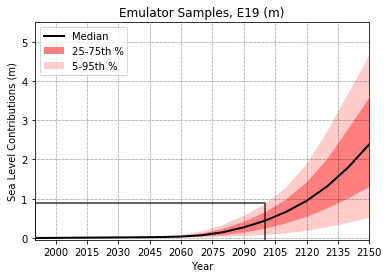

In [34]:
e19_U_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_e19_U[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_e19_U[0,:].T,
                    y2=quants_e19_U[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_e19_U[1,:].T,
                    y2=quants_e19_U[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_e19_U[3,:].T,
                    y2=quants_e19_U[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100
# rect=patches.Rectangle(xy=(1990,-0.2),width=110,height=1.1,linewidth=1.5, \
#                             linestyle='-',edgecolor='k',alpha=0.8,facecolor='none',zorder=50)
# ax.add_patch(rect)

plt.xlabel('Year')
plt.ylabel('Sea Level Contributions (m)')
plt.title('Emulator Samples, E19 (m)')
plt.legend(loc='upper left')
plt.axis('tight')
plt.xticks(np.linspace(2000,2150,11))
plt.yticks(np.linspace(0,10,11))
plt.ylim([-0.05,5.5])
plt.xlim([1990, 2150])
plt.show()

## K09-125ka: Time slice through 125ka from Kopp et al. (2009)

In [35]:
# find the posterior density through time
k09_125_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['k09_125'])

# find the quantiles for each time
quants_k09_125=find_quantile_ts(k09_125_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


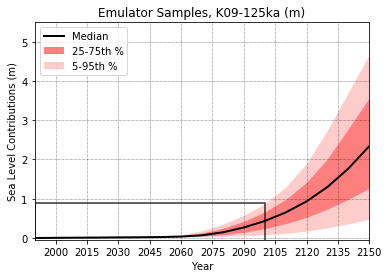

In [36]:
k09_125_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_k09_125[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_k09_125[0,:].T,
                    y2=quants_k09_125[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_k09_125[1,:].T,
                    y2=quants_k09_125[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_k09_125[3,:].T,
                    y2=quants_k09_125[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100
# rect=patches.Rectangle(xy=(1990,-0.2),width=110,height=1.1,linewidth=1.5, \
#                             linestyle='-',edgecolor='k',alpha=0.8,facecolor='none',zorder=50)
# ax.add_patch(rect)

plt.xlabel('Year')
plt.ylabel('Sea Level Contributions (m)')
plt.title('Emulator Samples, K09-125ka (m)')
plt.legend(loc='upper left')
plt.axis('tight')
plt.xticks(np.linspace(2000,2150,11))
plt.yticks(np.linspace(0,10,11))
plt.ylim([-0.05,5.5])
plt.xlim([1990, 2150])
plt.show()

## K09-Max-3kyrSmooth: Maximum of Each Kopp et al. (2009) sample (114-129ka)

In [37]:
# find the prior density through time (with "equal" likelihoods from the CC priors)
k09_max_3kyr_ts=posterior_densities_rcp85(step_locs,denorm_time,prior_norm,cc_likelihoods['k09_max_3kyr'])

# find the quantiles for each time
quants_k09_max_3kyr=find_quantile_ts(k09_max_3kyr_ts['cumulative_posterior_ts'],q,step_locs,denorm_time)

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


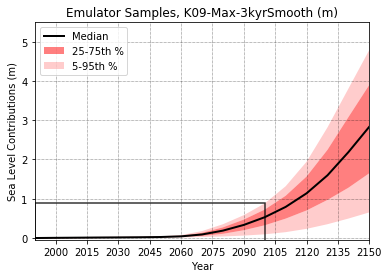

In [38]:
k09_max_3kyr_pdf_2150_ts=plt.figure(figsize=(6,4))
plt.grid()
plt.plot(denorm_time,quants_k09_max_3kyr[2,:],c='k',label='Median',lw=2)
ax = plt.subplot()
ax.fill_between(denorm_time, 
                    y1=quants_k09_max_3kyr[0,:].T,
                    y2=quants_k09_max_3kyr[1,:].T,
                    alpha=0.20, facecolor='r')
ax.fill_between(denorm_time, 
                    y1=quants_k09_max_3kyr[1,:].T,
                    y2=quants_k09_max_3kyr[3,:].T,
                    alpha=0.50, facecolor='r',label='25-75th %')
ax.fill_between(denorm_time, 
                    y1=quants_k09_max_3kyr[3,:].T,
                    y2=quants_k09_max_3kyr[4,:].T,
                    alpha=0.20, facecolor='r',label='5-95th %')

# add a box around 2100

plt.xlabel('Year')
plt.ylabel('Sea Level Contributions (m)')
plt.title('Emulator Samples, K09-Max-3kyrSmooth (m)')
plt.legend(loc='upper left')
plt.axis('tight')
plt.xticks(np.linspace(2000,2150,11))
plt.yticks(np.linspace(0,10,11))
plt.ylim([-0.05,5.5])
plt.xlim([1990, 2150])
plt.show()

# Posterior Probability Distributions at specific times

To show the value of LIG constraints for informing future projections, we plot the posterior probability distribution functions associated with each LIG constraint distribution specified above. These PDFs are simply timeslices of the above timeseries in 2100 and 2150.

## 2100 PDFs

In [39]:
denorm_time

array([ 1990.,  2000.,  2010.,  2020.,  2030.,  2040.,  2050.,  2060.,
        2070.,  2080.,  2090.,  2100.,  2110.,  2120.,  2130.,  2140.,
        2150.,  2160.,  2170.,  2180.,  2190.,  2200.])

In [41]:
# fill zeroes with missing data
fix_prior=prior_ts['posterior_ts'][prior_ts['posterior_ts']==0]=np.nan
fix_D20_U=D20_U_ts['posterior_ts'][D20_U_ts['posterior_ts']==0]=np.nan
fix_D20_N=D20_N_ts['posterior_ts'][D20_N_ts['posterior_ts']==0]=np.nan
fix_e19_U=e19_U_ts['posterior_ts'][e19_U_ts['posterior_ts']==0]=np.nan
fix_k09_125=k09_125_ts['posterior_ts'][k09_125_ts['posterior_ts']==0]=np.nan
fix_k09_max_3kyr=k09_max_3kyr_ts['posterior_ts'][k09_max_3kyr_ts['posterior_ts']==0]=np.nan

In [42]:
minval_2100,maxval_2100=-0.5,1.5
hist_bins=np.arange(minval_2100,maxval_2100+sl_step*1e01,step=sl_step*1e01)

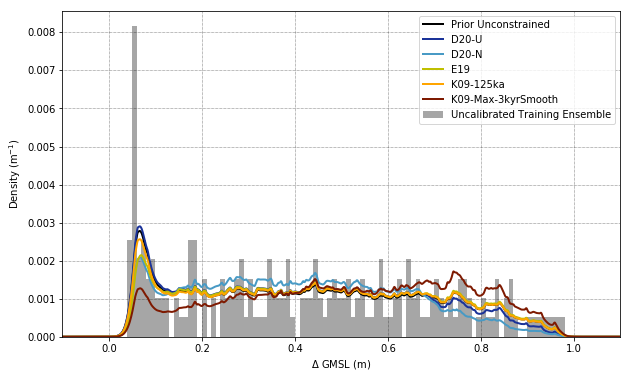

In [43]:
pdf_time=2100
emulated_pdfs2100_fig=plt.figure(figsize=(10,6))
plt.hist(np.squeeze(train_dat['Y_train'][train_dat['time']==pdf_time,:]),weights=np.ones(196)*(1/196)*(1e-1),bins=hist_bins,color='k',alpha=0.35,edgecolor='None',label='Uncalibrated Training Ensemble')
plt.plot(step_locs,prior_ts['posterior_ts'][:,denorm_time==pdf_time],c='k',lw=2,label='Prior Unconstrained')
plt.plot(step_locs,D20_U_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[0,:],lw=2,label='D20-U')
plt.plot(step_locs,D20_N_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[1,:],lw=2,label='D20-N')
plt.plot(step_locs,e19_U_ts['posterior_ts'][:,denorm_time==pdf_time],color='y',lw=2,label='E19')
plt.plot(step_locs,k09_125_ts['posterior_ts'][:,denorm_time==pdf_time],color='orange',lw=2,label='K09-125ka')
plt.plot(step_locs,k09_max_3kyr_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[4,:],lw=2,label='K09-Max-3kyrSmooth')
plt.ylabel('Density (m$^{-1}$)')
plt.xlabel('$\Delta$ GMSL (m)')
plt.axis('tight')
plt.xlim([-0.1,1.1])
plt.legend(loc='best',fontsize='medium')
plt.grid()
plt.show()

### 2150 PDFs

In [44]:
minval_2150,maxval_2150=-0.5,5.50
hist_bins_2150=np.arange(minval_2150,maxval_2150+sl_step*1e02,step=sl_step*1e02)

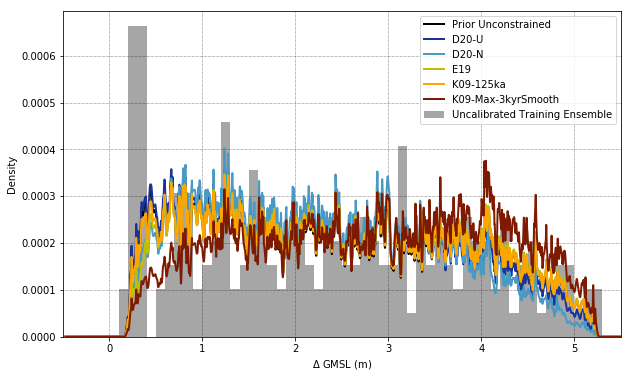

In [45]:
## pdf_time=2150
pdf_time=2150
emulated_pdfs2150_fig=plt.figure(figsize=(10,6))
plt.hist(np.squeeze(train_dat['Y_train'][train_dat['time']==pdf_time,:]),weights=np.ones(196)*(1/196)*(1e-2),bins=hist_bins_2150,color='k',alpha=0.35,edgecolor='None',label='Uncalibrated Training Ensemble')
plt.plot(step_locs,prior_ts['posterior_ts'][:,denorm_time==pdf_time],c='k',lw=2,label='Prior Unconstrained')
plt.plot(step_locs,D20_U_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[0,:],lw=2,label='D20-U')
plt.plot(step_locs,D20_N_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[1,:],lw=2,label='D20-N')
plt.plot(step_locs,e19_U_ts['posterior_ts'][:,denorm_time==pdf_time],color='y',lw=2,label='E19')
plt.plot(step_locs,k09_125_ts['posterior_ts'][:,denorm_time==pdf_time],color='orange',lw=2,label='K09-125ka')
plt.plot(step_locs,k09_max_3kyr_ts['posterior_ts'][:,denorm_time==pdf_time],color=cols[4,:],lw=2,label='K09-Max-3kyrSmooth')
plt.ylabel('Density')
plt.xlabel('$\Delta$ GMSL (m)')
plt.axis('tight')
plt.xlim([-0.5,5.50])
plt.legend(loc='best',fontsize='medium')
plt.grid()
plt.show()

### 2100 PDFs - Apply KDE

The above PDFs are incredibly noisy because of the discrete emulator sampling. Consistent with Edwards et al. (2019) we apply a kernel density estimation to each distribution to smooth and replot the distribution. To prevent oversmoothing, we substantially reduce (by 80%) the typically suggested Silvermann bandwidth, which when applied would lead to unphysical projections below 0 m in 2100 and 2150.

In [46]:
# define a function which resamples and properly scales the PDFs in prep. for KDE
def rescale_pdf_for_kde(step_locs,pdf_in):
    
    # import the packages we need
    import numpy as np
    
    # scale the PDF so that all values are whole numbers
    wholenum_pdf=np.round(pdf_in*10000,decimals=0)
    
    # set missing values in the whole number pdf to zero
    wholenum_pdf[np.isnan(wholenum_pdf)]=0
    
    # count the number of scaled samples we will work with, should be ~10k
    # note that the actual number of samples used to construct this distribution
    # was identically the size of the lhd
    n_kde=int(np.nansum(wholenum_pdf))
    
    # find the rescaled PDF on the same scale as the original data (known from step_locs)
    rescaled_pdf=np.empty((n_kde,),dtype='float')
    endpoint=0
    # loop over the bins
    for s in range(len(step_locs)):
        # get the count in this bin
        n_gt_zero=np.int(wholenum_pdf[s])
        # fill the bin counts with the the number in this bin, assigned the value of the bin
        if n_gt_zero>0:
            rescaled_pdf[endpoint:n_gt_zero+endpoint]=np.ones((n_gt_zero,),dtype='float')*step_locs[s]
            # update the index in the rescaled pdf vector
            endpoint=n_gt_zero+endpoint
    
    # go back to the above program level
    return(rescaled_pdf)

In [47]:
pdf_time=2100
# resample and rescale the PDFs
rescaled_prior=rescale_pdf_for_kde(step_locs,prior_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_D20_U=rescale_pdf_for_kde(step_locs,D20_U_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_D20_N=rescale_pdf_for_kde(step_locs,D20_N_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_e19_U=rescale_pdf_for_kde(step_locs,e19_U_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_k09_125=rescale_pdf_for_kde(step_locs,k09_125_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_k09_max_3kyr=rescale_pdf_for_kde(step_locs,k09_max_3kyr_ts['posterior_ts'][:,denorm_time==pdf_time])

In [48]:
# import the kde package
from scipy.stats import gaussian_kde
# define a scale factor, to reduce the smoothness of the Silverman bandwidth
scale_factor=np.float(1/5)
# perform the KDE and rescale the bandwidth to make it less unrealistically smooth
prior_kde=gaussian_kde(rescaled_prior,bw_method='silverman')
prior_kde.set_bandwidth(bw_method=prior_kde.factor*scale_factor)

D20_U_kde=gaussian_kde(rescaled_D20_U,bw_method='silverman')
D20_U_kde.set_bandwidth(bw_method=D20_U_kde.factor*scale_factor)

D20_N_kde=gaussian_kde(rescaled_D20_N,bw_method='silverman')
D20_N_kde.set_bandwidth(bw_method=D20_N_kde.factor*scale_factor)

e19_U_kde=gaussian_kde(rescaled_e19_U,bw_method='silverman')
e19_U_kde.set_bandwidth(bw_method=e19_U_kde.factor*scale_factor)

k09_125_kde=gaussian_kde(rescaled_k09_125,bw_method='silverman')
k09_125_kde.set_bandwidth(bw_method=k09_125_kde.factor*scale_factor)

k09_max_3kyr_kde=gaussian_kde(rescaled_k09_max_3kyr,bw_method='silverman')
k09_max_3kyr_kde.set_bandwidth(bw_method=k09_max_3kyr_kde.factor*scale_factor)

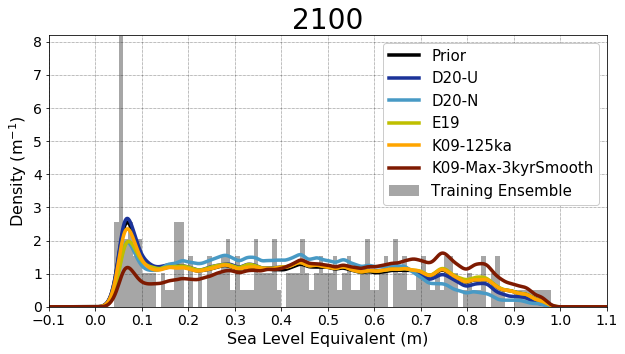

In [49]:
emulated_kde2100_fig=plt.figure(figsize=(10,5))
plt.hist(np.squeeze(train_dat['Y_train'][train_dat['time']==pdf_time,:]),weights=np.ones(196)*(1/196)*(1e2),bins=hist_bins,color='k',alpha=0.35,edgecolor='None',label='Training Ensemble')
plt.plot(step_locs,prior_kde(step_locs),c='k',lw=3.5,label='Prior')
plt.plot(step_locs,D20_U_kde(step_locs),color=cols[0,:],lw=3.5,label='D20-U')
plt.plot(step_locs,D20_N_kde(step_locs),color=cols[1,:],lw=3.5,label='D20-N')
plt.plot(step_locs,e19_U_kde(step_locs),color='y',lw=3.5,label='E19')
plt.plot(step_locs,k09_125_kde(step_locs),color='orange',lw=3.5,label='K09-125ka')
plt.plot(step_locs,k09_max_3kyr_kde(step_locs),color=cols[4,:],lw=3.5,label='K09-Max-3kyrSmooth')
plt.title('2100', fontsize=28)
plt.ylabel('Density (m$^{-1}$)',fontsize=16)
plt.xlabel('Sea Level Equivalent (m)',fontsize=16)
plt.xticks(np.linspace(-0.1,1.1,13),fontsize=14)
plt.yticks(np.linspace(0,9,10),fontsize=14)
plt.axis('tight')
plt.xlim([-0.1,1.1])
plt.ylim([0,8.2])
plt.legend(loc='best',fontsize=15,framealpha=1.0)
plt.grid()
plt.show()

In [50]:
# save the plot out
savename='Fig6a.pdf'
emulated_kde2100_fig.savefig(save_path+savename)

### 2150 PDFs - Apply KDE

In [51]:
pdf_time=2150
# resample and rescale the PDFs
rescaled_prior=rescale_pdf_for_kde(step_locs,prior_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_D20_U=rescale_pdf_for_kde(step_locs,D20_U_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_D20_N=rescale_pdf_for_kde(step_locs,D20_N_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_e19_U=rescale_pdf_for_kde(step_locs,e19_U_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_k09_125=rescale_pdf_for_kde(step_locs,k09_125_ts['posterior_ts'][:,denorm_time==pdf_time])
rescaled_k09_max_3kyr=rescale_pdf_for_kde(step_locs,k09_max_3kyr_ts['posterior_ts'][:,denorm_time==pdf_time])

In [52]:
# import the kde package
from scipy.stats import gaussian_kde
# define a scale factor, to reduce the smoothness of the Silverman bandwidth
scale_factor=np.float(1/4)
# perform the KDE and rescale the bandwidth to make it less unrealistically smooth
prior_kde=gaussian_kde(rescaled_prior,bw_method='silverman')
prior_kde.set_bandwidth(bw_method=prior_kde.factor*scale_factor)

D20_U_kde=gaussian_kde(rescaled_D20_U,bw_method='silverman')
D20_U_kde.set_bandwidth(bw_method=D20_U_kde.factor*scale_factor)

D20_N_kde=gaussian_kde(rescaled_D20_N,bw_method='silverman')
D20_N_kde.set_bandwidth(bw_method=D20_N_kde.factor*scale_factor)

e19_U_kde=gaussian_kde(rescaled_e19_U,bw_method='silverman')
e19_U_kde.set_bandwidth(bw_method=e19_U_kde.factor*scale_factor)

k09_125_kde=gaussian_kde(rescaled_k09_125,bw_method='silverman')
k09_125_kde.set_bandwidth(bw_method=k09_125_kde.factor*scale_factor)

k09_max_3kyr_kde=gaussian_kde(rescaled_k09_max_3kyr,bw_method='silverman')
k09_max_3kyr_kde.set_bandwidth(bw_method=k09_max_3kyr_kde.factor*scale_factor)

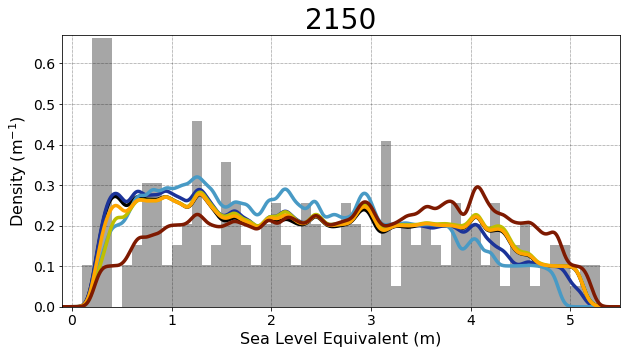

In [53]:
emulated_kde2150_fig=plt.figure(figsize=(10,5))
plt.hist(np.squeeze(train_dat['Y_train'][train_dat['time']==pdf_time,:]),weights=np.ones(196)*(1/196)*(1e1),bins=hist_bins_2150,color='k',alpha=0.35,edgecolor='None',label='Uncalibrated Training Ensemble')
plt.plot(step_locs,prior_kde(step_locs),c='k',lw=3.5,label='Prior Uncalibrated')
plt.plot(step_locs,D20_U_kde(step_locs),color=cols[0,:],lw=3.5,label='D20-U')
plt.plot(step_locs,D20_N_kde(step_locs),color=cols[1,:],lw=3.5,label='D20-N')
plt.plot(step_locs,e19_U_kde(step_locs),color='y',lw=3.5,label='E19')
plt.plot(step_locs,k09_125_kde(step_locs),color='orange',lw=3.5,label='K09-125ka')
plt.plot(step_locs,k09_max_3kyr_kde(step_locs),color=cols[4,:],lw=3.5,label='K09-Max-3kyrSmooth')
plt.title('2150', fontsize=28)
plt.ylabel('Density (m$^{-1}$)',fontsize=16)
plt.xlabel('Sea Level Equivalent (m)',fontsize=16)
plt.xticks(np.linspace(-1,9,11),fontsize=14)
plt.yticks(np.linspace(0,0.9,10),fontsize=14)
plt.axis('tight')
plt.xlim([-0.1,5.5])
plt.ylim([0,0.67])
#plt.legend(loc='best',fontsize='medium')
plt.grid()
plt.show()

In [54]:
# save the plot out
savename='Fig6b.pdf'
emulated_kde2150_fig.savefig(save_path+savename)

## Plot the Skew over time as a function of the LIG constraint

Comparing with Robel et al. (2019), we expect that AIS mass losses should have a skewed distribution which grows over time for a particular ice-sheet subject to ice-sheet instabilities. This skew halts, however, if the mass loss saturates because the ice-sheet disappears. It is complicated in this study's simulations, because there are number of different basins which are responding to ice-sheet instabilities at various times. However, at least at first (before mass loss saturation) skews should grow over time.

We investigate this and show how the skew can vary depending on the LIG constraint considered.

In [55]:
skewt_prior=np.zeros((len(denorm_time,)),dtype='float64')
skewt_D20_U=np.zeros((len(denorm_time,)),dtype='float64')
skewt_low=np.zeros((len(denorm_time,)),dtype='float64')
skewt_high=np.zeros((len(denorm_time,)),dtype='float64')
for t in range(len(denorm_time)):
    rescaled_prior_t=rescale_pdf_for_kde(step_locs,prior_ts['posterior_ts'][:,t])
    rescaled_D20_U_t=rescale_pdf_for_kde(step_locs,D20_U_ts['posterior_ts'][:,t])
    rescaled_low_t=rescale_pdf_for_kde(step_locs,low_U_ts['posterior_ts'][:,t])
    rescaled_high_t=rescale_pdf_for_kde(step_locs,high_U_ts['posterior_ts'][:,t])
    skewt_prior[t,]=scipy.stats.skew(rescaled_prior_t)
    skewt_D20_U[t,]=scipy.stats.skew(rescaled_D20_U_t)
    skewt_low[t,]=scipy.stats.skew(rescaled_low_t)
    skewt_high[t,]=scipy.stats.skew(rescaled_high_t)

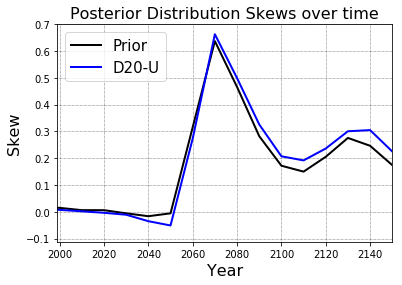

In [56]:
plt.figure()
plt.plot(denorm_time,skewt_prior,'k',lw=2,label='Prior')
plt.plot(denorm_time,skewt_D20_U,'b',lw=2,label='D20-U')
plt.xlim([1999, 2150])
plt.title('Posterior Distribution Skews over time',fontsize=16)
plt.ylabel('Skew',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.legend(loc='upper left',fontsize=15)
plt.grid()
plt.show()

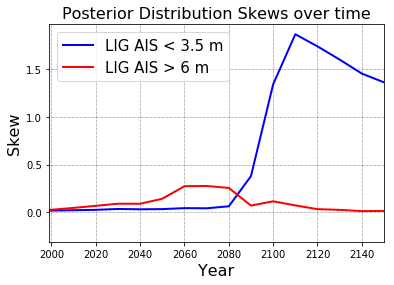

In [57]:
plt.figure()
plt.plot(denorm_time,skewt_low,'b',lw=2,label='LIG AIS < 3.5 m')
plt.plot(denorm_time,skewt_high,'r',lw=2,label='LIG AIS > 6 m')
plt.xlim([1999, 2150])
plt.title('Posterior Distribution Skews over time',fontsize=16)
plt.ylabel('Skew',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.legend(loc='upper left',fontsize=15)
plt.grid()
plt.show()

## RCP8.5 Conditional Probability Distributions as a function of the LIG

Here we explore what very narrow constraints on the LIG distribution---i.e., assuming that changes during the LIG were known to within 10cm---would mean for the distribution of the RCP8.5 projections. This approach to find the conditional probabilities is both generalized and useful in specific ways, e.g. one can integrate over the distributions shown here with weightings from specific constraints to recover the associated posterior of the RCP8.5 distribution.

For every 10-cm-wide constraint (which is considered a uniform distribution of 10cm width, see **sample_lig_emulator.ipynb**), there is a likelihood of CREVLIQ/CLIFVMAX values at each sample location. Using those likelihoods, we determine the RCP8.5 distribution conditional on the LIG.

### Load data for conditional probability analyses:

In [58]:
# load the idealized array data dictionary
idealized_dat=pickle.load(open( "./models/lig_posteriors.pk1", "rb" ) )
# get the number of bins
n_bins=len(idealized_dat['lig_posteriors'])
print(n_bins)

51


### Sample the LIG and RCP8.5 emulators with the weights associated with each 10-cm-wide bin

In [59]:
# limit the distributions to just 2100 and 2150, by building a new (limited over to these two times) prior:
index_nums = [ind2100,ind2150]
prior_mean_slice = np.squeeze([prior_mean[val,:] for val in index_nums])
prior_var_slice  = np.squeeze([prior_var[val,:] for val in index_nums])
denorm_time_slice= np.squeeze([denorm_time[val] for val in index_nums])
prior_norm_slice=norm(loc=prior_mean_slice,scale=np.sqrt(prior_var_slice))

In [60]:
# define the LIG bins to perform the idealized density estimation
slid_step=1e-02
idealized_step_locs=np.arange(min_val,max_val+slid_step,step=slid_step)
# define the RCP85 to perform the idealized density estimation
step_locs_2100=idealized_step_locs
step_locs_2150=np.arange(min_val,max_val+slid_step*1e1,step=slid_step*1e1)

In [61]:
# create the array that we need for storing analysis
posterior_pdfs_2100=np.empty((n_bins,len(step_locs_2100)),dtype='float')
posterior_pdfs_2150=np.empty((n_bins,len(step_locs_2150)),dtype='float')

# loop over bins to find the posterior quantiles
for b in range(n_bins):
    
    # find the posterior RCP for this bin
    post_bin_2100=posterior_densities_rcp85(step_locs_2100,denorm_time_slice,prior_norm_slice,idealized_dat['lig_posteriors'][b]['param_density'])
    post_bin_2150=posterior_densities_rcp85(step_locs_2150,denorm_time_slice,prior_norm_slice,idealized_dat['lig_posteriors'][b]['param_density'])
    
    # store the RCP samples at 2100 and 2150
    posterior_pdfs_2100[b,:]=np.squeeze(post_bin_2100['posterior_ts'][:,0])
    posterior_pdfs_2150[b,:]=np.squeeze(post_bin_2150['posterior_ts'][:,1])
    
    # normalize the result in each column
    posterior_pdfs_2100[b,:]=posterior_pdfs_2100[b,:]/np.sum(posterior_pdfs_2100[b,:])
    posterior_pdfs_2150[b,:]=posterior_pdfs_2150[b,:]/np.sum(posterior_pdfs_2150[b,:])
    
    # tell the user where we are
    print(b)
    
    # delete things before starting a new loop
    del post_bin_2100
    del post_bin_2150

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


### Plot the Results in 2100 and 2150

In [62]:
# color levels necessary for the contouring
clevels=np.linspace(np.log(1e-3),np.log(0.3),11)
clabels=np.round(np.exp(clevels),decimals=3).astype('str')

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

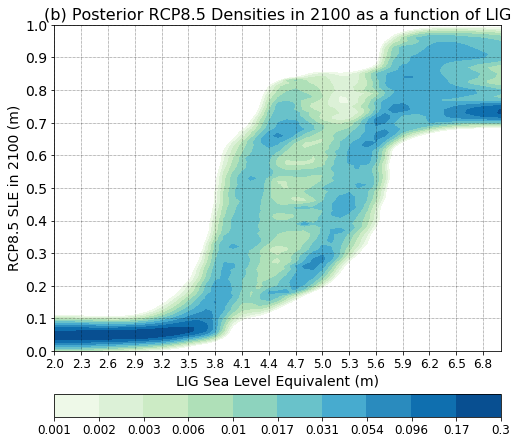

In [63]:
# plot the result for 2100
plt.set_cmap('GnBu')
lig_rcp_jointpdf_2100_fig=plt.figure(figsize=(8,8))
c1=plt.contourf(idealized_dat['idealized_mid_steps'],idealized_step_locs,np.log(posterior_pdfs_2100.T),clevels)
cbar=plt.colorbar(c1,ticks=clevels,orientation='horizontal',pad=0.1)
cbar.set_ticklabels(clabels)
cbar.ax.tick_params(labelsize=12)
plt.xticks(idealized_dat['idealized_mid_steps'][::3],fontsize=12)
plt.yticks(np.linspace(0.,1.0,11),fontsize=14)
plt.ylim([0,1.0])
plt.xlim([2.,7.0])
plt.title('(b) Posterior RCP8.5 Densities in 2100 as a function of LIG',fontsize=16)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('RCP8.5 SLE in 2100 (m)',fontsize=14)
plt.grid()
plt.show()

In [64]:
# save the plot out
savename='Fig4b.pdf'
lig_rcp_jointpdf_2100_fig.savefig(save_path+savename)

In [65]:
# color levels necessary for the contouring
clevels2=np.linspace(np.log(1e-3),np.log(0.6),11)
clabels2=np.round(np.exp(clevels2),decimals=3).astype('str')

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


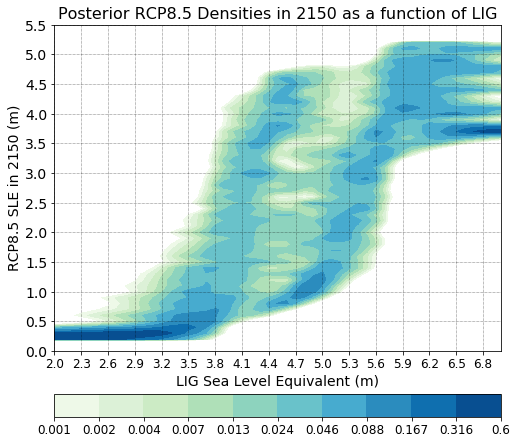

In [66]:
# plot the result for 2150
lig_rcp_jointpdf_2150_fig=plt.figure(figsize=(8,8))
c2=plt.contourf(idealized_dat['idealized_mid_steps'],step_locs_2150,np.log(posterior_pdfs_2150.T),clevels2)
cbar=plt.colorbar(c2,ticks=clevels2,orientation='horizontal',pad=0.1)
cbar.set_ticklabels(clabels2)
cbar.ax.tick_params(labelsize=12)
plt.xticks(idealized_dat['idealized_mid_steps'][::3],fontsize=12)
plt.yticks(np.linspace(0.,5.50,12),fontsize=14)
plt.ylim([0,5.50])
plt.xlim([2.,7.0])
plt.title('Posterior RCP8.5 Densities in 2150 as a function of LIG',fontsize=16)
plt.xlabel('LIG Sea Level Equivalent (m)',fontsize=14)
plt.ylabel('RCP8.5 SLE in 2150 (m)',fontsize=14)
plt.grid()
plt.show()

In [67]:
# save the plot out
savename='FigS6.pdf'
lig_rcp_jointpdf_2150_fig.savefig(save_path+savename)

## RCP8.5 Uncertainty Change with LIG Uncertainty Growth

Here we show how the range of the future sea-level rise projection uncertainties (in 2100) as predicted by the emulator vary as the function of the range of LIG uncertainties. This analysis becomes the basis for Figure 8, calculated in **visualize_lig_error_importance.ipynb**.

In [68]:
import math
# define the central bins that we will explore the uncertainty around with this method
central_bins=idealized_dat['idealized_mid_steps'][0::5]
central_i=np.arange(len(idealized_dat['idealized_mid_steps']))[0::5]
# define the uncertaionty ranges that will define the area we search
uncertainty_ranges=np.linspace(0,3,31)
uncertainty_i=np.arange(len(uncertainty_ranges))

# define the quantiles we want
qb=np.asarray([2.5,97.5],dtype='int')
# create the array we need to store the data
quants_b=np.empty((len(central_bins),len(uncertainty_ranges),2),dtype='float64')

# loop over the bins and find the quantile ranges in RCP8.5 associated with each
for b in range(len(central_bins)):
    
    # loop over the uncertainty ranges
    for r in range(len(uncertainty_ranges)):
        
        # find the bins to integrate over
        low_bound,up_bound=central_i[b]-uncertainty_i[r],central_i[b]+uncertainty_i[r]
        if low_bound<0:
            low_bound=0
        if up_bound>len(idealized_dat['idealized_mid_steps']):
            up_bound=len(idealized_dat['idealized_mid_steps'])
            
        # find the integrated densitities over the bins in question
        integrated_pdf=np.sum(posterior_pdfs_2100[low_bound:up_bound,:],axis=0)
        norm_pdf=integrated_pdf/np.sum(integrated_pdf)
        
        if math.isnan(norm_pdf[0]):
            quants_get=0
            quants_b[b,r,:]=0
            
        else:
            
            #ouch
            quants_get=find_quantile_ts(np.cumsum(norm_pdf).reshape(len(step_locs_2100),1),qb,step_locs_2100,[0])
            quants_b[b,r,:]=np.squeeze(quants_get)
        
        # reset
        del quants_get, norm_pdf, integrated_pdf, up_bound, low_bound
#         print(b)
#         print(r)
    

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


In [69]:
import matplotlib.pylab as pl
colors = pl.cm.viridis(np.linspace(0,1,len(central_bins)-4))

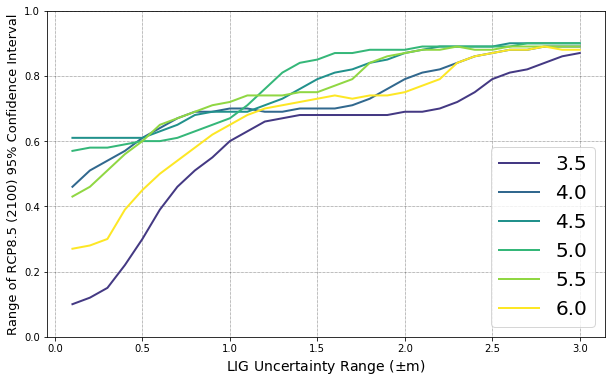

In [70]:
ci_range_LIG_uncertainty=plt.figure(figsize=(10,6))
for b in range(len(central_bins)):
    if b>2 and b<len(central_bins)-2:
        plt.plot(uncertainty_ranges[1:],(quants_b[b,:,1]-quants_b[b,:,0])[1:],label=str(central_bins[b]),color=colors[b-2],lw=2)
    
plt.grid()
plt.ylim([0,1.0])
plt.xlabel('LIG Uncertainty Range ($\pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Confidence Interval',fontsize=13)
plt.legend(loc='best',fontsize=20)
plt.show()

## Save out Data

In [71]:
# store and save the data from the conditional calculations
output_dat={'conditional_dat':idealized_dat, 'posterior_2100':posterior_pdfs_2100, 'posterior_2150':posterior_pdfs_2150,'step_locs_2100':step_locs_2100,'step_locs_2150':step_locs_2150}
pickle.dump(output_dat, open( "./models/conditional_data.pk1", "wb" ) )

## Table of Quantiles

Here we print the quantiles that we found above in 2100 and 2150, in meters.

In [73]:
import pandas as pd
ind2100=np.where(denorm_time==2100)
ind2150=np.where(denorm_time==2150)
stack_2100=np.hstack((quants_prior[:,ind2100],quants_D20_U[:,ind2100],quants_D20_N[:,ind2100], \
                                    quants_e19_U[:,ind2100],quants_k09_125[:,ind2100], \
                                    quants_k09_max_3kyr[:,ind2100]))
stack_2150=np.hstack((quants_prior[:,ind2150],quants_D20_U[:,ind2150],quants_D20_N[:,ind2150], \
                                    quants_e19_U[:,ind2150],quants_k09_125[:,ind2150], \
                                    quants_k09_max_3kyr[:,ind2150]))
frame_2100=pd.DataFrame(np.squeeze(stack_2100),columns=['Prior','D20-U','D20-N','E19-U','K09-125ka','K09-Max-3kyrSmooth'],index=q)
frame_2150=pd.DataFrame(np.squeeze(stack_2150),columns=['Prior','D20-U','D20-N','E19-U','K09-125ka','K09-Max-3kyrSmooth'],index=q)

In [74]:
# change the number of precision digits to show in Pandas
pd.set_option('precision', 2)

In [75]:
frame_2100

,Prior,D20-U,D20-N,E19-U,K09-125ka,K09-Max-3kyrSmooth
5,0.07,0.07,0.07,0.07,0.07,0.09
25,0.20,0.20,0.23,0.23,0.22,0.32
50,0.42,0.40,0.40,0.44,0.43,0.53
75,0.64,0.61,0.58,0.65,0.64,0.72
95,0.85,0.83,0.78,0.85,0.85,0.88


In [76]:
frame_2150

,Prior,D20-U,D20-N,E19-U,K09-125ka,K09-Max-3kyrSmooth
5,0.44,0.44,0.51,0.52,0.46,0.65
25,1.21,1.17,1.23,1.30,1.25,1.65
50,2.31,2.21,2.18,2.39,2.34,2.84
75,3.54,3.38,3.22,3.58,3.55,3.91
95,4.65,4.56,4.38,4.66,4.64,4.80
